<a href="https://colab.research.google.com/github/lucasbaldezzari/babesbayes-nma/blob/seoheehan94-patch-1/Laquitaine%26Gardner_Population_model_Seohee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span> <font color='3A40A2'>Bayes babes: Laquitaine & Gardner - Population model</font> </span>


In [ ]:
#@title importing libraries
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import i0
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from google.colab import drive
drive.mount('/content/drive')
py_file_location = "/content/drive/MyDrive/Colab Notebooks"
sys.path.append(os.path.abspath(py_file_location))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Define parameters
motion_coherence = [0.06, 0.12, 0.24]
coherence_to_kappa = {
    0.06: 1,
    0.12: 3,
    0.24: 5
} # random kappa assigned for now
prior_std = [10, 20, 40, 80]
priorStd_to_kappa = {
    10: 33,
    20: 8.7,
    40: 2.8,
    80: 0.7
}
mean_direction_deg = 225  # mean direction in degrees
num_trials = 1000  # example number of trials

In [ ]:
#print(np.deg2rad(10))
#print(1/(np.deg2rad(10))**2)
#prior_kappa = [1.0 / (np.deg2rad(std) ** 2) for std in prior_std]
#print(prior_kappa) # similar enough I guess...

In [ ]:
#@title generate inputs

# Generate direction values from Von Mises distribution
def generate_von_mises_data(kappa, num_trials, mean_direction_deg):
  """
    Args:
    kappa: concentration parameter of the Von Mises distribution.
    num_trials: number of trials
    mean_direction_degree: mean direction in degreess.

    Returns:
    array of sampled directions in degrees.
  """
  # Convert mean direction to radians
  mean_direction_rad = np.deg2rad(mean_direction_deg)

  # Generate direction values from Von Mises distribution
  directions_rad = stats.vonmises.rvs(kappa, loc=mean_direction_rad, size=num_trials)

  # Convert directions back to degrees
  directions_deg = np.rad2deg(directions_rad) % 360

  # Define the valid direction steps
  valid_directions = np.arange(5, 360, 10)

  # Map each direction to the nearest valid value
  mapped_directions = np.array([valid_directions[np.argmin(np.abs(valid_directions - direction))] for direction in directions_deg])


  return mapped_directions


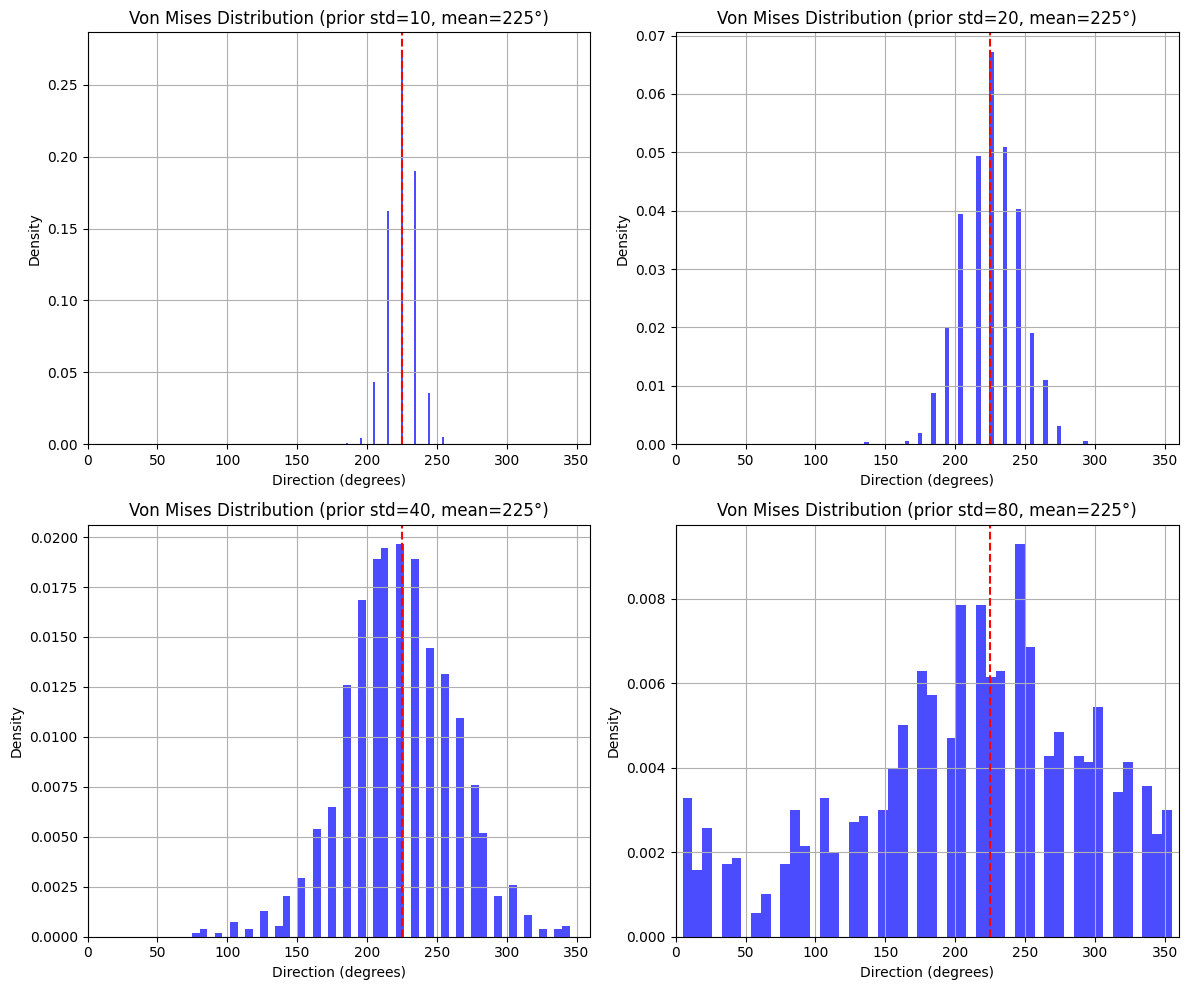

In [ ]:
#@title plot the sample input distribution

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Generate and plot data for each concentration
for i, (prior_std, kappa) in enumerate(priorStd_to_kappa.items()):
    directions_deg = generate_von_mises_data(kappa, num_trials, mean_direction_deg)


    # Plot histogram on the respective subplot
    row = i // 2
    col = i % 2
    axs[row, col].hist(directions_deg, bins=50, density=True, alpha=0.7, color='blue')
    axs[row, col].set_title(f'Von Mises Distribution (prior std={prior_std}, mean={mean_direction_deg}°)')
    axs[row, col].set_xlabel('Direction (degrees)')
    axs[row, col].set_ylabel('Density')
    axs[row, col].grid(True)
    axs[row, col].set_xlim([0, 360])
    axs[row, col].axvline(x=225, color='red', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()

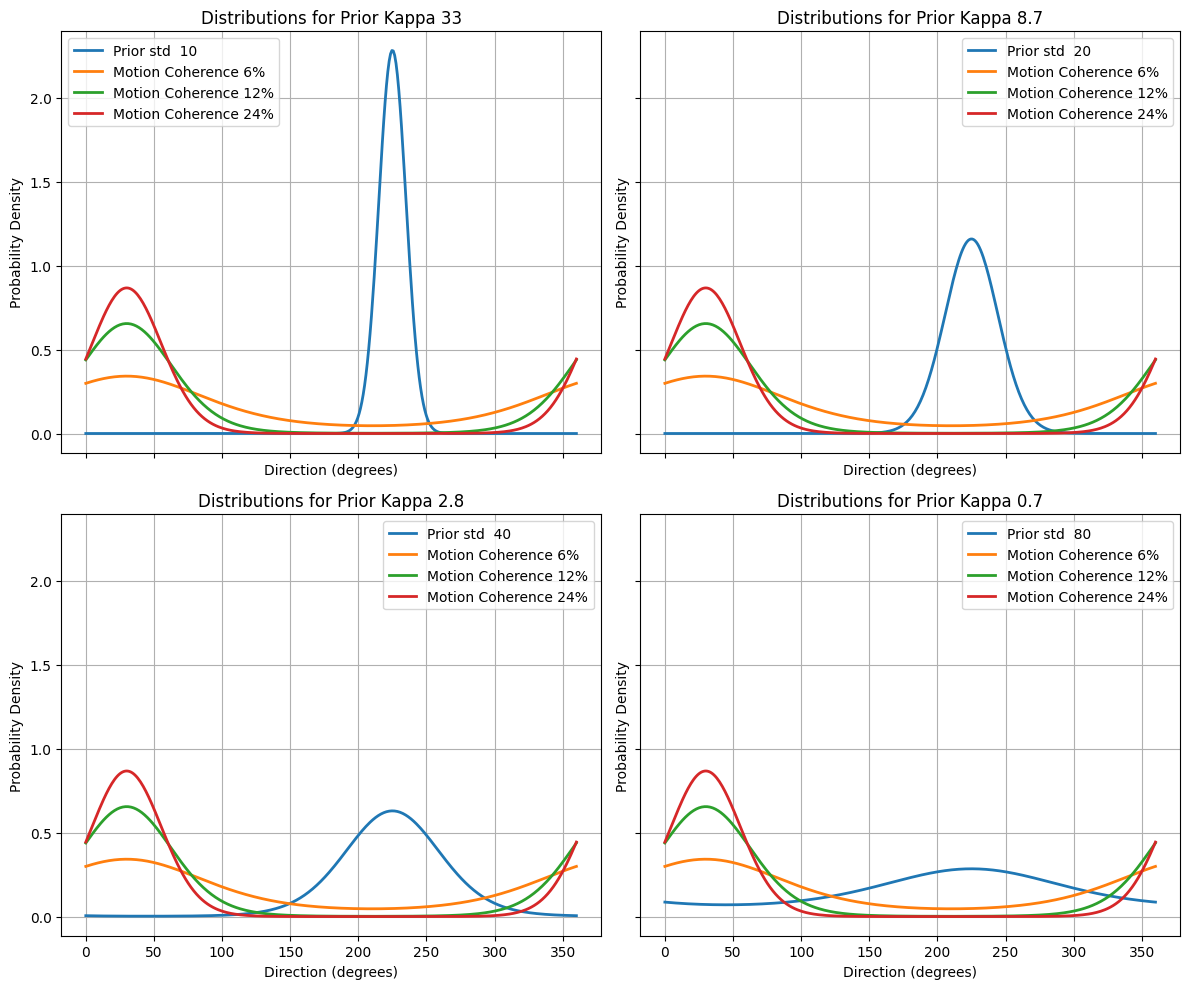

In [ ]:
#@title Generate prior and sensory distribution

# Number of samples
n_samples = 1000

true_motion_deg = 30 #play with this variable

# Function to generate Von Mises distributed data
def von_mises_pdf(kappa, mean_direction_deg):
    mean_direction_rad = np.deg2rad(mean_direction_deg)  # Prior mean in radians
    x = np.linspace(0, 2*np.pi, 360)
    y = stats.vonmises.pdf(x, kappa, loc=mean_direction_rad)
    x_deg = np.rad2deg(x)
    return x_deg, y

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for idx, (prior_std, kappa) in enumerate(priorStd_to_kappa.items()):
    row = idx // 2
    col = idx % 2

    # Plot prior distribution
    x_deg, y = von_mises_pdf(kappa, mean_direction_deg)
    axs[row, col].plot(x_deg, y, label=f'Prior std  {prior_std}', linewidth=2)

    # Plot evidence distributions
    for coherence, kappa_evidence in coherence_to_kappa.items():
        x_deg, y = von_mises_pdf(kappa_evidence, true_motion_deg)
        axs[row, col].plot(x_deg, y, label=f'Motion Coherence {coherence*100:.0f}%', linewidth=2)

    axs[row, col].set_title(f'Distributions for Prior Kappa {kappa}')
    axs[row, col].set_xlabel('Direction (degrees)')
    axs[row, col].set_ylabel('Probability Density')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [ ]:
#@title Implement the Switching observer Model

def switching_model(directions_deg, motion_coherence, mean_direction_deg, prior_kappa, weight2prior):
    """
    Simulate the switching heuristic model with a prior distribution.

    Args:
    directions_deg: array of input directions in degrees.
    motion_coherence: coherence level of the motion stimulus.
    mean_direction_deg: mean direction of the prior distribution in degrees.
    prior_kappa: concentration parameter (kappa) of the prior distribution.

    Returns:
    estimates: array of estimated motion directions.
    """

    # Get the kappa for the sensory evidence
    kappa_evidence = coherence_to_kappa[motion_coherence]

    # probabilitiy of choosing prior
    P_prior = prior_kappa/(prior_kappa + kappa_evidence)

    # Convert degrees to radians
    directions_rad = np.deg2rad(directions_deg)
    mean_direction_rad = np.deg2rad(mean_direction_deg)

    estimates = []

    for direction_rad in directions_rad:

      # Generate a random number between 0 and 1
        rand_num = np.random.rand()

      # Make a decision based on the probability
        if rand_num < P_prior:
            estimate = stats.vonmises.rvs(max(prior_kappa + weight2prior, 0), loc=mean_direction_rad)
        else:
            estimate = stats.vonmises.rvs(max(kappa_evidence, 0), loc=direction_rad)

        # Ensure the estimate is within 0-360 degrees
        estimate = np.rad2deg(estimate) % 360
        estimates.append(estimate)

    return np.array(estimates)

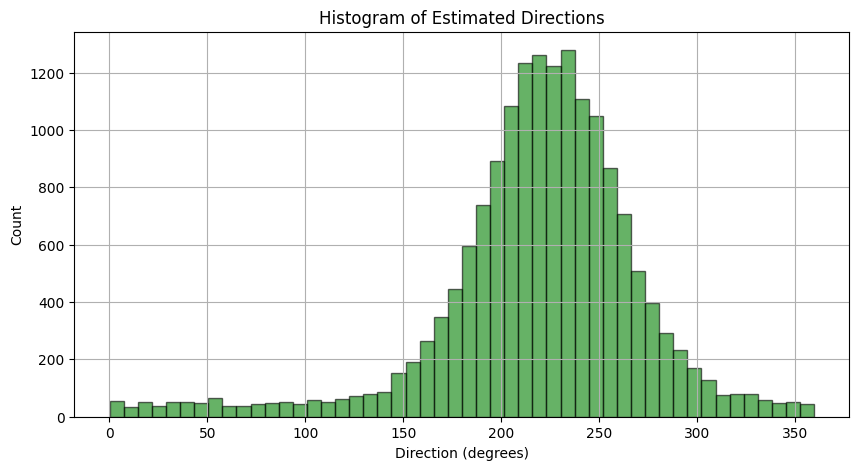

In [ ]:
# Example usage
prior_kappa = 0.7  # Example concentration parameter
motion_coherence = 0.06  # Example coherence level
num_trials = 16665
mean_direction_deg =225
directions_deg = generate_von_mises_data(prior_kappa, num_trials, mean_direction_deg)
weight2prior = 2.5
estimates = switching_model(directions_deg, motion_coherence, mean_direction_deg, prior_kappa, weight2prior)

# Plot the estimated directions
plt.figure(figsize=(10, 5))
plt.hist(estimates, bins=50, alpha=0.6, color='g', edgecolor='black')
plt.xlabel('Direction (degrees)')
plt.ylabel('Count')
plt.title('Histogram of Estimated Directions')
plt.grid(True)
plt.show()

In [ ]:
# Get the kappa for the sensory evidence
kappa_evidence = coherence_to_kappa[motion_coherence]
prior_kappa = 0.7
# probabilitiy of choosing prior
P_prior = prior_kappa/(prior_kappa + kappa_evidence)
print(P_prior)

0.4117647058823529


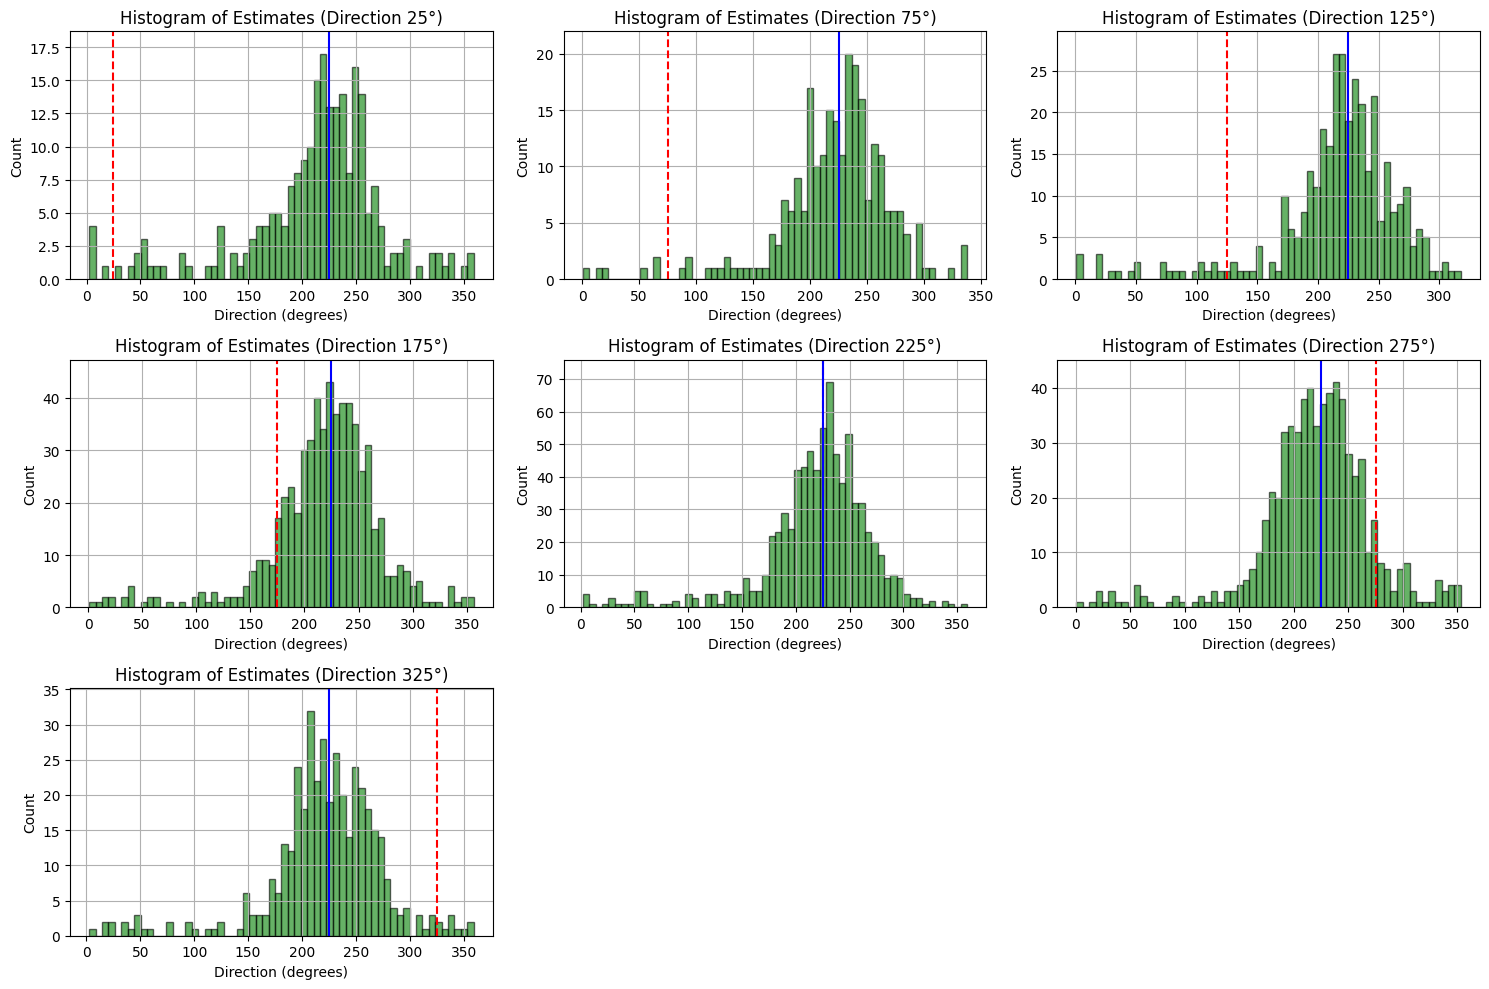

In [ ]:
# True directions to plot
true_directions = [25, 75, 125, 175, 225, 275, 325]

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plotting
for i, test_direction in enumerate(true_directions):
    # Filter estimates for the current test direction
    mask = directions_deg == test_direction
    filtered_estimates = estimates[mask]

    # Create subplot
    row = i // 3
    col = i % 3

    # Plot histogram
    counts, bins, patches = axs[row, col].hist(filtered_estimates, bins=60, density=False, alpha=0.6, color='g', edgecolor='black')

    axs[row, col].set_title(f'Histogram of Estimates (Direction {test_direction}°)')
    axs[row, col].set_xlabel('Direction (degrees)')
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_ylim(0, max(counts) * 1.1)  # Set the y-axis limit slightly above the maximum count
    axs[row, col].grid(True)

    # Mark the true direction with a red dashed line
    axs[row, col].axvline(x=test_direction, color='red', linestyle='--')

    # Mark prior mean with a blue solid line
    axs[row, col].axvline(x=225, color='blue', linestyle='-')

# Remove empty subplots if there are any
for j in range(len(true_directions), 9):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

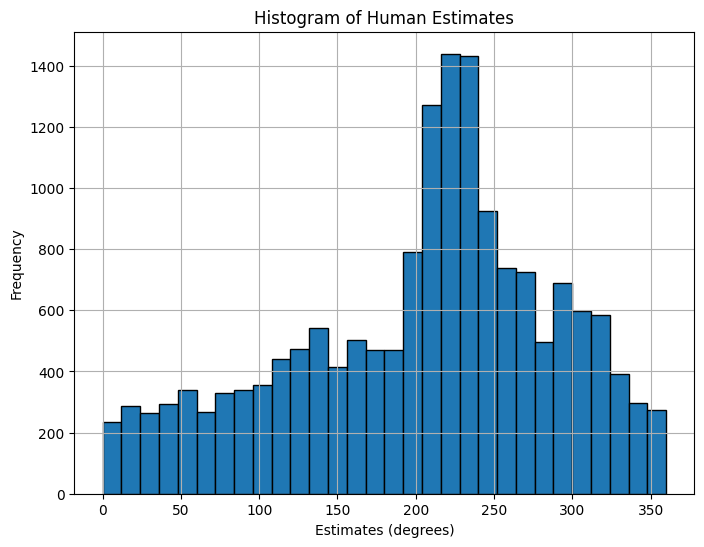

In [ ]:
#@title Import Human Data
# get human_data
human_data = pd.read_csv("drive/My Drive/School/phD/phD3/NeuroMatch/project/data01_direction4priors_processed.csv")

# Filter the data for motion_coherence = 0.06 and prior_std = 80
filtered_data = human_data[(human_data['motion_coherence'] == 0.06) & (human_data['prior_std'] == 80)]
filtered_estimates = filtered_data['estimates_deg'].values

# Ensure both arrays are the same length
valid_indices = ~np.isnan(filtered_estimates) & ~np.isnan(estimates)
filtered_estimates = filtered_estimates[valid_indices]
estimates = estimates[valid_indices]

plt.figure(figsize=(8, 6))
plt.hist(filtered_estimates, bins=30, edgecolor='black')
plt.xlabel('Estimates (degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Human Estimates')
plt.grid(True)
plt.show()

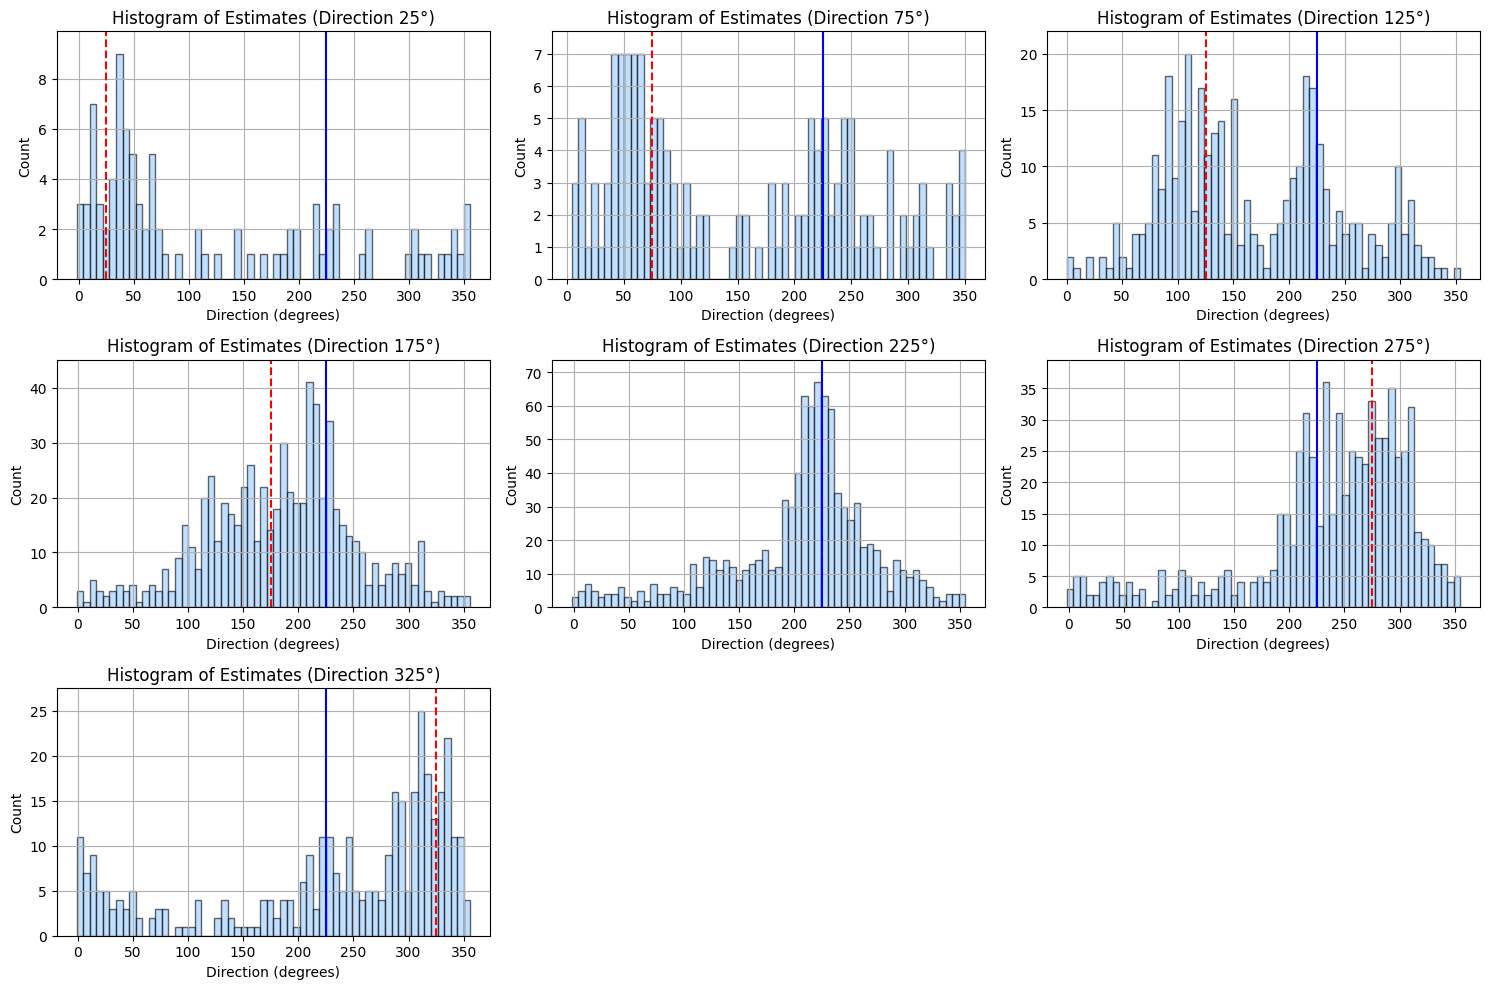

In [ ]:
# Define the directions to plot
true_directions = [25, 75, 125, 175, 225, 275, 325]

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plotting
for i, test_direction in enumerate(true_directions):
    # Filter the data for the current direction
    filtered_data = human_data[(human_data['motion_coherence'] == 0.06) &
                               (human_data['prior_std'] == 80) &
                               (human_data['motion_direction'] == test_direction)]

    filtered_estimates = filtered_data['estimates_deg'].values

    # Remove NaN values from filtered_estimates
    filtered_estimates = filtered_estimates[~np.isnan(filtered_estimates)]

    # Check if there are enough values to plot
    if len(filtered_estimates) == 0:
        continue

    # Create subplot
    row = i // 3
    col = i % 3
    counts, bins = np.histogram(filtered_estimates, bins=60, density=False)

    # Plot the histogram
    axs[row, col].bar(bins[:-1], counts, width=np.diff(bins), alpha=0.6, color=(0.6, 0.8, 1.0), edgecolor='black')
    axs[row, col].set_title(f'Histogram of Estimates (Direction {test_direction}°)')
    axs[row, col].set_xlabel('Direction (degrees)')
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_ylim(0, max(counts) * 1.1)  # Set the y-axis limit slightly above the maximum count
    axs[row, col].grid(True)

    # Mark the true direction with a red dashed line
    axs[row, col].axvline(x=test_direction, color='red', linestyle='--')

    # Mark prior mean with a blue solid line
    axs[row, col].axvline(x=225, color='blue', linestyle='-')

# Remove empty subplots if there are any
for j in range(len(true_directions), 9):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [ ]:
#@title Fit Models to Human Data

# Compute the circular distance between two angles in degrees.
def circular_distance(angle1, angle2):
    delta = np.abs(angle1 - angle2) % 360
    return np.minimum(delta, 360 - delta)

# mean squared distance
def mean_squared_distance(human_data, estimates):
    distances = circular_distance(human_data, estimates)
    squared_distances = distances ** 2
    return np.mean(squared_distances)

# compute log likelihood of the observed data given the model estimates
def calculate_log_likelihood(human_data, estimates, prior_kappa, kappa_evidence, mean_direction_deg, P_prior):

    mean_direction_rad = np.deg2rad(mean_direction_deg)
    human_data_rad = np.deg2rad(human_data)
    estimates_rad = np.deg2rad(estimates)

    # Likelihood for prior distribution
    likelihood_prior = np.exp(prior_kappa * np.cos(human_data_rad - mean_direction_rad)) / (2 * np.pi * i0(prior_kappa))

    # Likelihood for evidence distribution
    likelihood_evidence = np.exp(kappa_evidence * np.cos(human_data_rad - estimates_rad)) / (2 * np.pi * i0(kappa_evidence))

    # Weighted likelihood
    weighted_likelihood = P_prior * likelihood_prior + (1 - P_prior) * likelihood_evidence

    # Calculate overall likelihood (product of individual likelihoods)
    overall_likelihood = np.prod(weighted_likelihood)

    # Add a small constant to avoid log(0)
    epsilon = 1e-10
    overall_likelihood = max(overall_likelihood, epsilon)

    # Compute log-likelihood
    log_likelihood = np.log(overall_likelihood)

    return log_likelihood

# calculate AIC
def calculate_aic(human_data, estimates, prior_kappa, kappa_evidence, mean_direction_deg, P_prior, num_params):

    # Compute the log-likelihood of the observed data given the model estimates
    log_likelihood = calculate_log_likelihood(human_data, estimates, prior_kappa, kappa_evidence, mean_direction_deg, P_prior)

    # Calculate AIC
    aic = 2 * num_params - 2 * log_likelihood

    return aic


In [ ]:
# Fit and compare models
msd = mean_squared_distance(filtered_estimates,estimates)
print(f"Mean Squared Distance for Switching Model: {msd}")

num_params = 3
aic = calculate_aic(filtered_estimates, estimates, prior_kappa, kappa_evidence, mean_direction_deg, P_prior, num_params)
print(f"AIC: {aic}")


Mean Squared Distance for Switching Model: 8989.747763547555
AIC: 52.051701859880914


In [ ]:
#@title Optimize the Parameters
# Define the NLL function
def negative_log_likelihood(human_estimates, model_estimates, concentration):
    # Calculate the von Mises probability density function for each estimate
    pdf = stats.vonmises.pdf(human_estimates, concentration, loc=model_estimates)

    # Replace zero probabilities with a small value to avoid log(0)
    pdf = np.clip(pdf, 1e-10, None)

    # Calculate the negative log-likelihood
    nll = -np.sum(np.log(pdf))
    return nll

# Define the optimization objective function
def objective(params, directions_deg, human_estimates, mean_direction_deg, prior_kappa):
    coherence_to_kappa[0.06] = params[0]
    weight2prior = params[1]
    model_estimates = switching_model(directions_deg, 0.06, mean_direction_deg, prior_kappa, weight2prior)

    # Ensure both arrays are the same length and filter NaNs
    valid_indices = ~np.isnan(human_estimates) & ~np.isnan(model_estimates)
    filtered_human_estimates = human_estimates[valid_indices]
    filtered_model_estimates = model_estimates[valid_indices]

    # Calculate NLL
    concentration = coherence_to_kappa[0.06]  # Use the kappa value for von Mises
    nll = negative_log_likelihood(filtered_human_estimates, filtered_model_estimates, concentration)
    print(f"Parameters: {params}, coherence_kappa: {coherence_to_kappa[0.06]}, NLL: {nll}")  # Debug print
    return nll

# Define the optimization function
def optimize_parameters(directions_deg, human_estimates, mean_direction_deg, prior_kappa):
    # Initial guesses for kappa and weight2prior
    initial_guess = [1.0, 1.0]

    # Define bounds for kappa and weight2prior
    bounds = [(0.1, 5.0), (0.0, 10.0)]

    # Perform optimization
    result = minimize(objective, initial_guess, args=(directions_deg, human_estimates, mean_direction_deg, prior_kappa), bounds=bounds)

    return result.x, result.fun

# Define the grid search function with data collection
def grid_search(directions_deg, human_estimates, mean_direction_deg, prior_kappa):
    # Define the range of values for each parameter
    kappa_values = np.linspace(0.1, 5.0, 5)  # 5 values between 0.1 and 5.0
    weight2prior_values = np.linspace(-0.6, 5, 8)  # 8 values between -0.6 and 8.0

    # Lists to store parameter values and corresponding NLLs
    all_kappa = []
    all_weight2prior = []
    all_nll = []

    best_nll = float('inf')
    best_params = None

    for kappa in kappa_values:
        for weight2prior in weight2prior_values:
            params = [kappa, weight2prior]
            nll = objective(params, directions_deg, human_estimates, mean_direction_deg, prior_kappa)

            # Store parameter values and NLL
            all_kappa.append(kappa)
            all_weight2prior.append(weight2prior)
            all_nll.append(nll)

            if nll < best_nll:
                best_nll = nll
                best_params = params

            print(f"Grid search params: {params}, NLL: {nll}")  # Debug print

    return best_params, best_nll, all_kappa, all_weight2prior, all_nll

Parameters: [0.1, -0.6], coherence_kappa: 0.1, NLL: 30671.47955356225
Grid search params: [0.1, -0.6], NLL: 30671.47955356225
Parameters: [0.1, 0.19999999999999996], coherence_kappa: 0.1, NLL: 30674.102862531694
Grid search params: [0.1, 0.19999999999999996], NLL: 30674.102862531694
Parameters: [0.1, 0.9999999999999999], coherence_kappa: 0.1, NLL: 30660.608418277607
Grid search params: [0.1, 0.9999999999999999], NLL: 30660.608418277607
Parameters: [0.1, 1.7999999999999998], coherence_kappa: 0.1, NLL: 30669.320392066977
Grid search params: [0.1, 1.7999999999999998], NLL: 30669.320392066977
Parameters: [0.1, 2.5999999999999996], coherence_kappa: 0.1, NLL: 30646.735381799524
Grid search params: [0.1, 2.5999999999999996], NLL: 30646.735381799524
Parameters: [0.1, 3.3999999999999995], coherence_kappa: 0.1, NLL: 30669.95175320519
Grid search params: [0.1, 3.3999999999999995], NLL: 30669.95175320519
Parameters: [0.1, 4.2], coherence_kappa: 0.1, NLL: 30677.98477840511
Grid search params: [0.1,

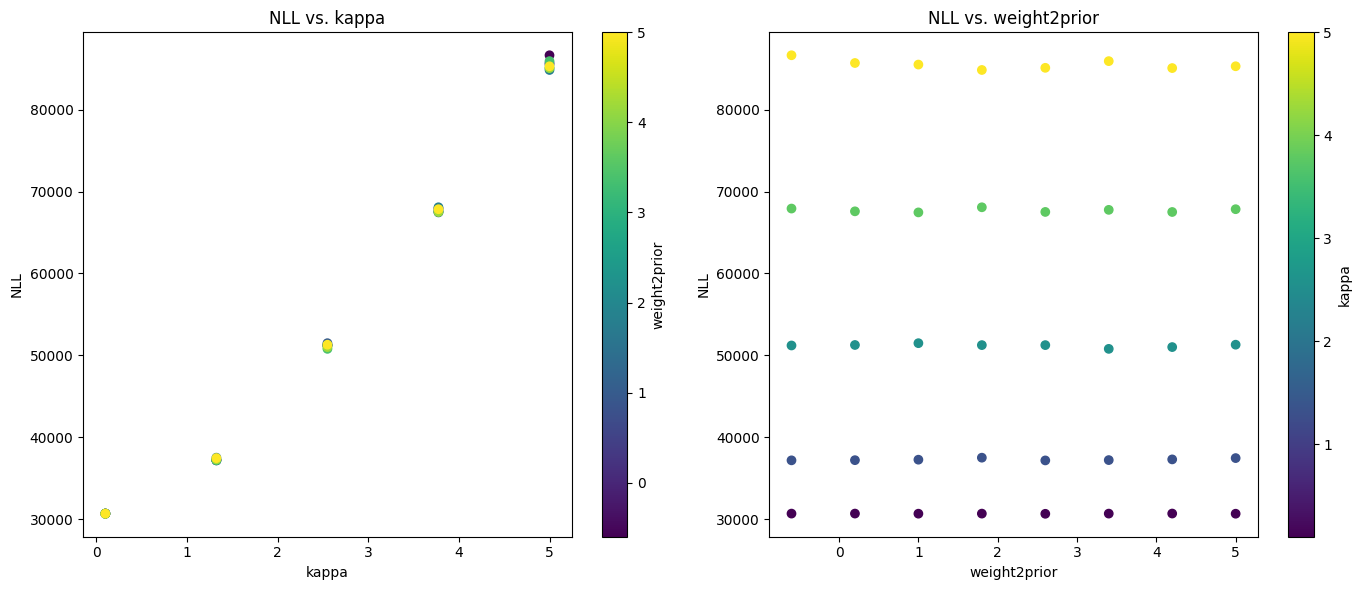

In [ ]:
# Filter the data for motion_coherence = 0.06 and prior_std = 80
filtered_data = human_data[(human_data['motion_coherence'] == 0.06) & (human_data['prior_std'] == 80)]
filtered_estimates = filtered_data['estimates_deg'].values

# Mean direction and prior kappa (fixed for the example)
mean_direction_deg = 225
prior_kappa = 0.7

# Perform grid search
best_params, best_nll, all_kappa, all_weight2prior, all_nll = grid_search(directions_deg, filtered_estimates, mean_direction_deg, prior_kappa)

# Get the best-fitting parameters
best_kappa_evidence = best_params[0]
best_weight2prior = best_params[1]
coherence_to_kappa[0.06] = best_kappa_evidence

print(f"Best kappa_evidence for coherence 0.06: {best_kappa_evidence}")
print(f"Best weight2prior: {best_weight2prior}")
print(f"Best Negative Log-Likelihood: {best_nll}")

# Calculate the NLL with the best-fitting parameters
best_model_estimates = switching_model(directions_deg, 0.06, mean_direction_deg, prior_kappa, best_weight2prior)
valid_indices = ~np.isnan(filtered_estimates) & ~np.isnan(best_model_estimates)
filtered_human_estimates = filtered_estimates[valid_indices]
filtered_model_estimates = best_model_estimates[valid_indices]
nll = negative_log_likelihood(filtered_human_estimates, filtered_model_estimates, coherence_to_kappa[0.06])

print(f"Negative Log-Likelihood: {nll}")

# Plot the results
plt.figure(figsize=(14, 6))

# Plot NLL vs. kappa
plt.subplot(1, 2, 1)
scatter = plt.scatter(all_kappa, all_nll, c=all_weight2prior, cmap='viridis')
plt.colorbar(scatter, label='weight2prior')
plt.xlabel('kappa')
plt.ylabel('NLL')
plt.title('NLL vs. kappa')

# Plot NLL vs. weight2prior
plt.subplot(1, 2, 2)
scatter = plt.scatter(all_weight2prior, all_nll, c=all_kappa, cmap='viridis')
plt.colorbar(scatter, label='kappa')
plt.xlabel('weight2prior')
plt.ylabel('NLL')
plt.title('NLL vs. weight2prior')

plt.tight_layout()
plt.show()


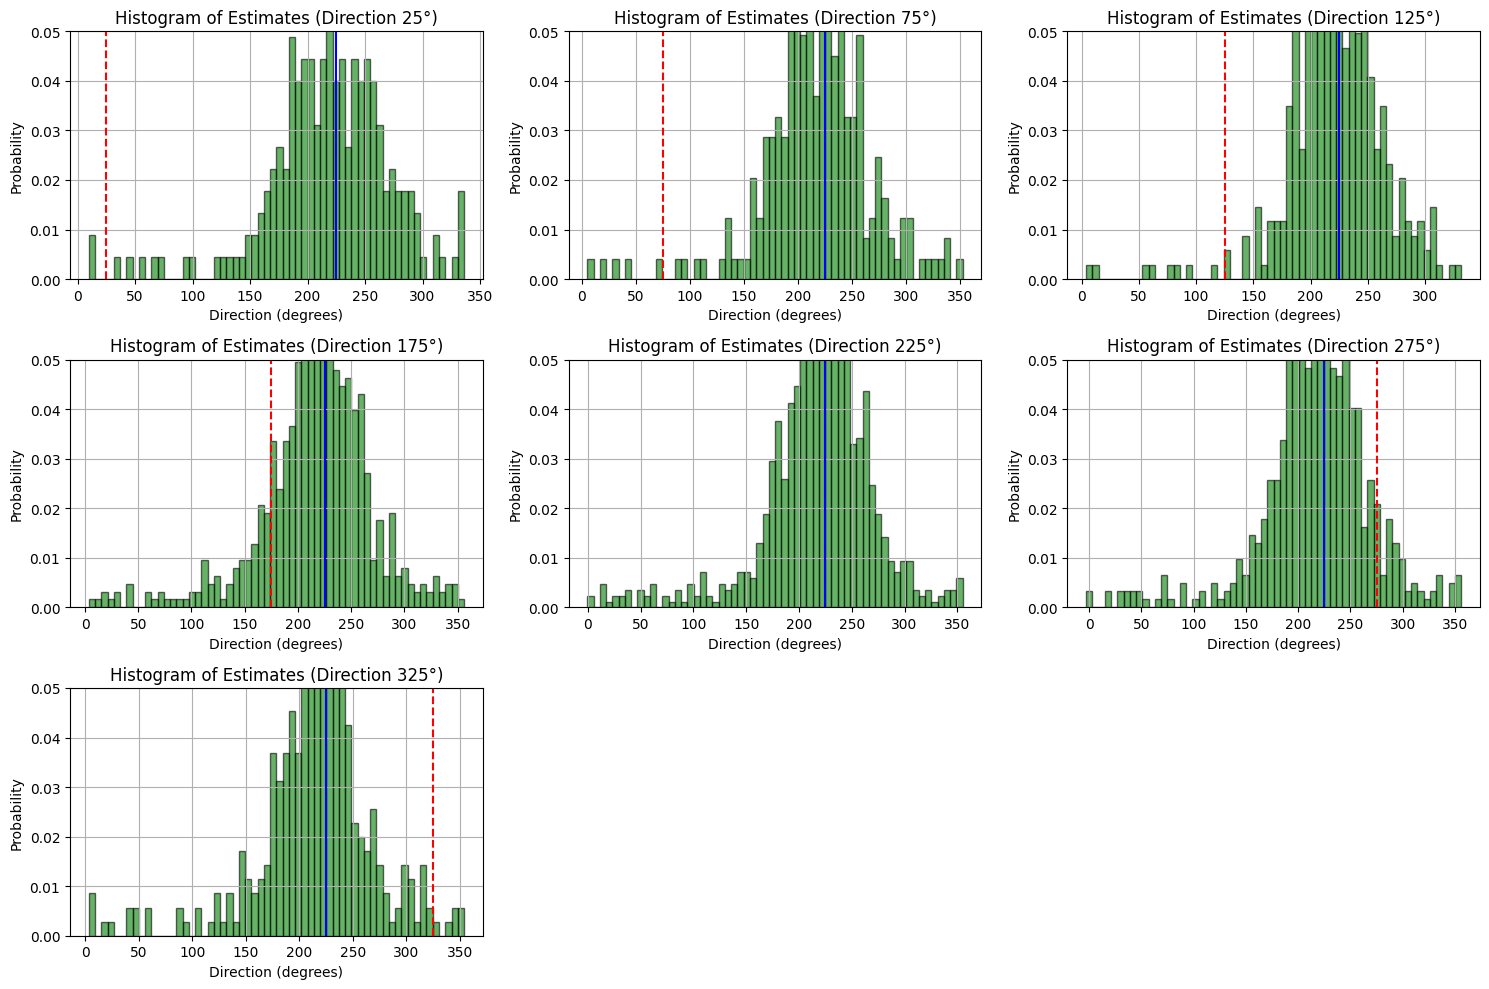

In [ ]:
#@title Plot again with best parameters
# True directions to plot
true_directions = [25, 75, 125, 175, 225, 275, 325]

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plotting
for i, test_direction in enumerate(true_directions):
    # Filter estimates for the current test direction
    mask = directions_deg == test_direction
    filtered_estimates = best_model_estimates[mask]

    # Create subplot
    row = i // 3
    col = i % 3
    counts, bins, patches = axs[row, col].hist(filtered_estimates, bins=60, density=True, alpha=0.6, color='g', edgecolor='black')

    # Normalize the counts to get probabilities
    total_counts = np.sum(counts)
    probabilities = counts / total_counts

    # Clear the current histogram
    axs[row, col].cla()

    # Plot the probabilities
    axs[row, col].bar(bins[:-1], probabilities, width=np.diff(bins), alpha=0.6, color='g', edgecolor='black')
    axs[row, col].set_title(f'Histogram of Estimates (Direction {test_direction}°)')
    axs[row, col].set_xlabel('Direction (degrees)')
    axs[row, col].set_ylabel('Probability')
    axs[row, col].set_ylim(0, 0.05)  # Set the y-axis limit
    axs[row, col].grid(True)

    # Mark the true direction with a red dashed line
    axs[row, col].axvline(x=test_direction, color='red', linestyle='--')

    # Mark prior mean with a blue solid line
    axs[row, col].axvline(x=225, color='blue', linestyle='-')


# Remove empty subplots if there are any
for j in range(len(true_directions), 9):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()